### **Problem statement**: To build a CNN based model which can accurately detect melanoma. 

In [1]:
import warnings
warnings.filterwarnings('ignore')


#### Import needed libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from keras.utils.vis_utils import plot_model

In [3]:
## This notebook is being run in Kaggle, checking if GPU is enabled
tf.config.list_physical_devices('GPU')

2022-11-16 16:50:09.990207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 16:50:09.991408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 16:50:10.125647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 16:50:10.126565: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 16:50:10.127325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [4]:
## Define the trainging and test path directories
## For this assignment, moved Test and Train folders into parent folder melimgs 
## and uploaded zip to kaggale input directory

data_dir_train = pathlib.Path("/kaggle/input/melimgs/Train")
data_dir_test = pathlib.Path("/kaggle/input/melimgs/Test")

In [5]:
## Using pathlib glob module, print the count of images

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train images count= ", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test images count= ", image_count_test)

Train images count=  2239
Test images count=  118


#### Define parameters batch size and image dimensions

In [6]:
batch_size = 32
img_height = 180
img_width = 180

#### Load training images, perform a 80(train) and 20(validation) split

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


2022-11-16 16:50:10.554159: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-16 16:50:10.824890: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 16:50:10.825846: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-16 16:50:10.826691: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


#### Load Test data provided to make predictions once model is trained

In [9]:
## Load test data fro final predictions (no test train split here)
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width))

## Get the file path
test_file_paths = test_ds.file_paths

## Store the file name and given class in the Test directory in data frame
test_ds_given_df=pd.DataFrame()
for file in test_file_paths:
    test_ds_given_df= test_ds_given_df.append({"GivenClass":file.split('/')[-2],"GivenFile":file.split('/')[-1]},ignore_index=True)

Found 118 files belonging to 9 classes.


In [10]:
## reset the index for test files data frame to filename
test_ds_given_df=test_ds_given_df.set_index("GivenFile")
test_ds_given_df

,GivenClass
GivenFile,
ISIC_0024511.jpg,actinic keratosis
ISIC_0024408.jpg,pigmented benign keratosis
ISIC_0000035.jpg,melanoma
ISIC_0024358.jpg,pigmented benign keratosis
ISIC_0024454.jpg,basal cell carcinoma
...,...
ISIC_0011751.jpg,squamous cell carcinoma
ISIC_0010809.jpg,seborrheic keratosis
ISIC_0024412.jpg,pigmented benign keratosis


#### Obtain the class names in train data

In [11]:
class_names = train_ds.class_names
print(class_names)
print("Total Clases:" , len(class_names))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Total Clases: 9


#### Print image from each class for visualization

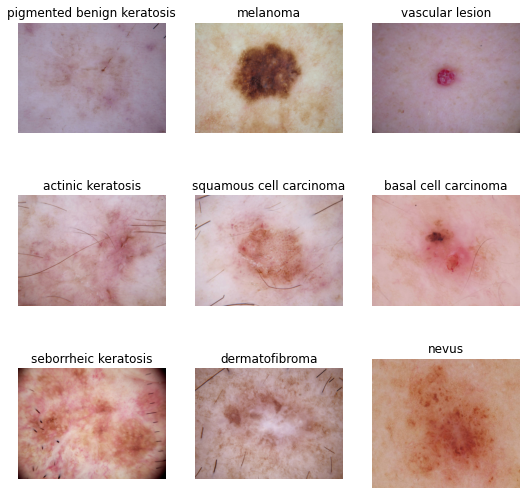

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 9))
i=0;
for dirpath, dirnames, files in os.walk(str(data_dir_train)):    
    for file in [f for f in files if f.endswith(".jpg")][:1]:
        img = PIL.Image.open(str(dirpath)+"/"+str(file))
        plt.subplot(3,3,i+1)
        plt.title(str(dirpath).split('/')[-1])
        plt.axis('off')
        plt.imshow(img)
        i=i+1
 
    

#### Performance related settings
Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model 1 : Basic Model 

In [14]:
model1 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(180,180, 3)),
  tf.keras.layers.Conv2D(32, 3, padding="same",activation='relu'),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), 
  tf.keras.layers.Conv2D(64, 3, padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(len(class_names),activation='softmax')
])

In [15]:
# summary of the model
print(model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 180, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 90, 90, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0

In [16]:
# compile the model with sgd optimizer
model1.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [17]:
# Training the model
m1_fit = model1.fit(train_ds, batch_size=batch_size,epochs=25,validation_data=val_ds,shuffle=True)

Epoch 1/25


2022-11-16 16:50:16.912954: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-16 16:50:27.249920: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 29 of 1000
2022-11-16 16:50:31.994205: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-11-16 16:50:33.198949: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


56/56 [==============================] - 31s 119ms/step - loss: 2.8142 - accuracy: 0.3326 - val_loss: 2.1793 - val_accuracy: 0.1678
Epoch 2/25
56/56 [==============================] - 2s 42ms/step - loss: 1.4311 - accuracy: 0.4972 - val_loss: 2.7564 - val_accuracy: 0.1834
Epoch 3/25
56/56 [==============================] - 2s 44ms/step - loss: 1.2164 - accuracy: 0.5686 - val_loss: 3.0870 - val_accuracy: 0.1834
Epoch 4/25
56/56 [==============================] - 2s 43ms/step - loss: 1.0238 - accuracy: 0.6300 - val_loss: 2.9172 - val_accuracy: 0.2125
Epoch 5/25
56/56 [==============================] - 2s 42ms/step - loss: 0.8760 - accuracy: 0.6881 - val_loss: 3.7197 - val_accuracy: 0.1790
Epoch 6/25
56/56 [==============================] - 2s 42ms/step - loss: 0.7185 - accuracy: 0.7405 - val_loss: 4.0227 - val_accuracy: 0.2081
Epoch 7/25
56/56 [==============================] - 2s 42ms/step - loss: 0.5903 - accuracy: 0.7863 - val_loss: 2.2904 - val_accuracy: 0.3535
Epoch 8/25
56/56 [====

* Observation for Model 1 : Training accuracy of 83% Validation accuracy of 52%
* Inference: Clearly there is an overfit. Also accuracy is low as probably layers in the model are not enough

## Model 2 : Build a custom VGG16 model

In [28]:
model2 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(180,180, 3)),
  tf.keras.layers.Conv2D(64, 3, padding="same",activation='relu'),
  tf.keras.layers.Conv2D(64, 3, padding="same",activation='relu'),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)), 
  tf.keras.layers.Conv2D(128, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(128, 3, padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)),
  tf.keras.layers.Conv2D(256, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(256, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(256, 3, padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(),     
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(len(class_names),activation='softmax')
])

In [29]:
# compile the model with adam optimizer
model2.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

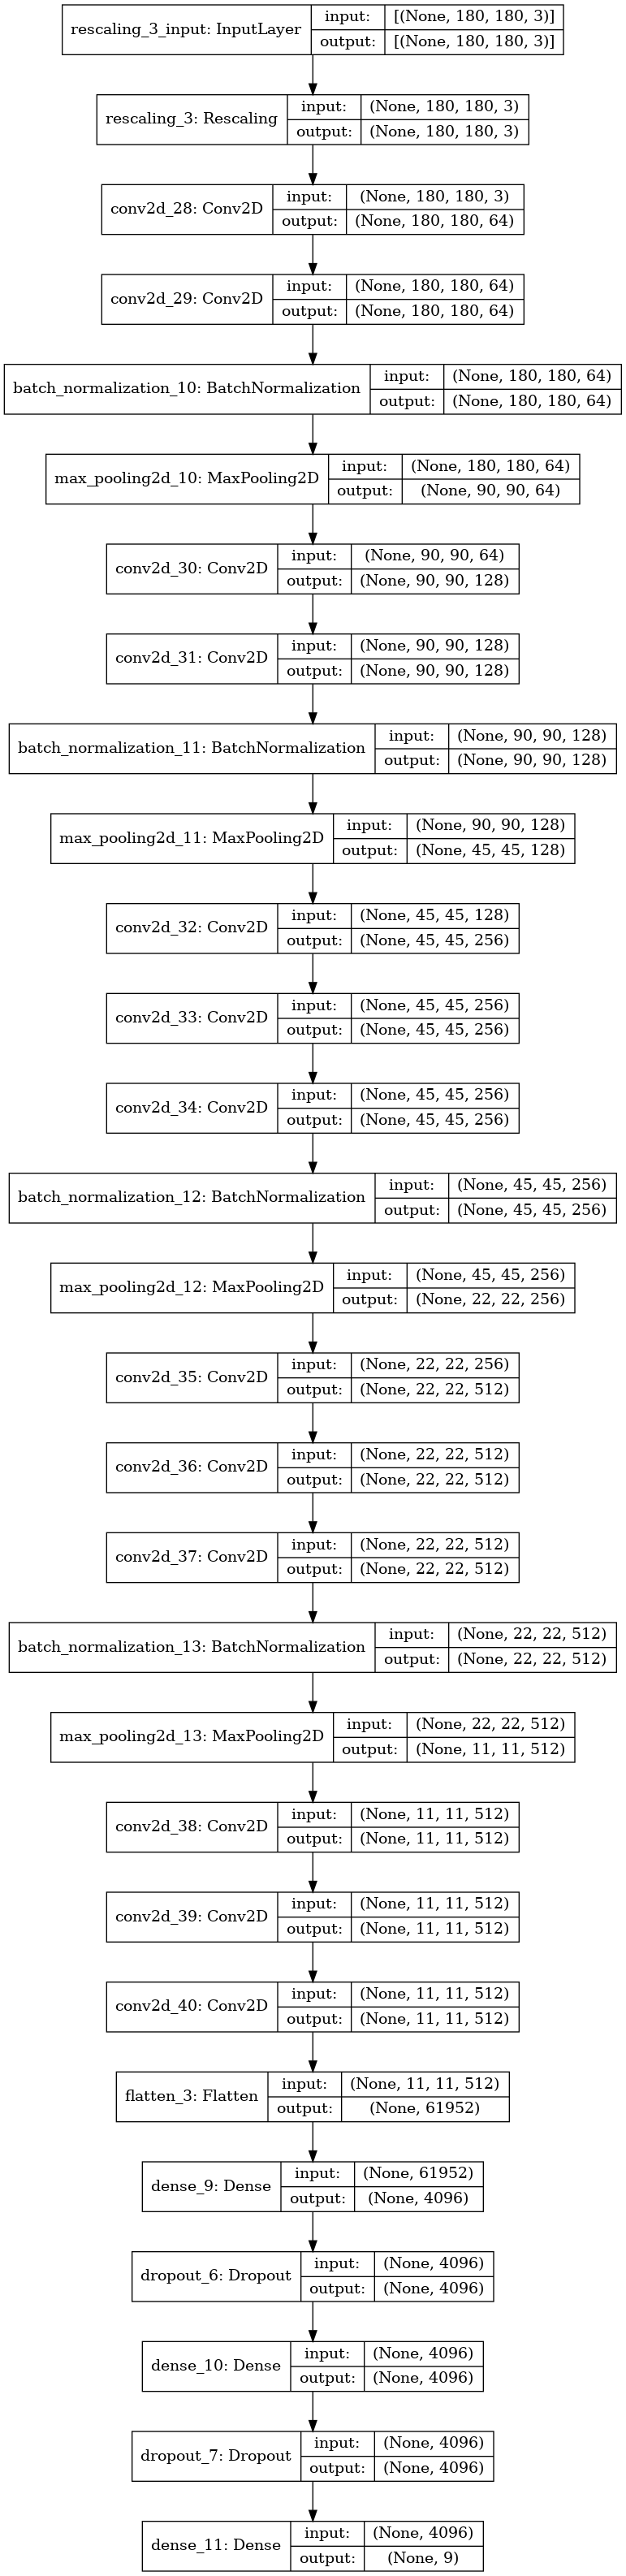

In [30]:
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [31]:
# summary of the model
print(model2.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 180, 180, 64)      1792      
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 180, 180, 64)      36928     
_________________________________________________________________
batch_normalization_10 (Batc (None, 180, 180, 64)      256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 90, 90, 128)       73856     
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 90, 90, 128)      

In [32]:
# Training the model
m2_fit = model2.fit(train_ds, batch_size=batch_size,epochs=25,validation_data=val_ds,shuffle=True)

Epoch 1/25
56/56 [==============================] - 22s 367ms/step - loss: 1.9758 - accuracy: 0.3002 - val_loss: 2.1746 - val_accuracy: 0.2058
Epoch 2/25
56/56 [==============================] - 21s 382ms/step - loss: 1.6393 - accuracy: 0.4141 - val_loss: 2.2429 - val_accuracy: 0.1499
Epoch 3/25
56/56 [==============================] - 21s 372ms/step - loss: 1.4813 - accuracy: 0.4754 - val_loss: 2.2589 - val_accuracy: 0.1499
Epoch 4/25
56/56 [==============================] - 22s 390ms/step - loss: 1.4131 - accuracy: 0.4972 - val_loss: 2.2547 - val_accuracy: 0.1499
Epoch 5/25
56/56 [==============================] - 21s 373ms/step - loss: 1.3353 - accuracy: 0.5218 - val_loss: 2.5995 - val_accuracy: 0.1499
Epoch 6/25
56/56 [==============================] - 21s 371ms/step - loss: 1.2813 - accuracy: 0.5318 - val_loss: 2.4696 - val_accuracy: 0.1655
Epoch 7/25
56/56 [==============================] - 21s 376ms/step - loss: 1.2110 - accuracy: 0.5636 - val_loss: 2.6843 - val_accuracy: 0.1767

* Observation for Model 2 : Even with a custom VGG16 model the validation accuracy has not increased
* Inference: Clearly there is an overfit. Also accuracy is low as probably layers in the model are not enough

In [33]:
def plt_model (model_fit,epochs):
    train_acc = model_fit.history['accuracy']
    val_acc = model_fit.history['val_accuracy']
    
    train_loss = model_fit.history['loss']
    val_loss = model_fit.history['val_loss']
    
    epochs_range = range(epochs)
    
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

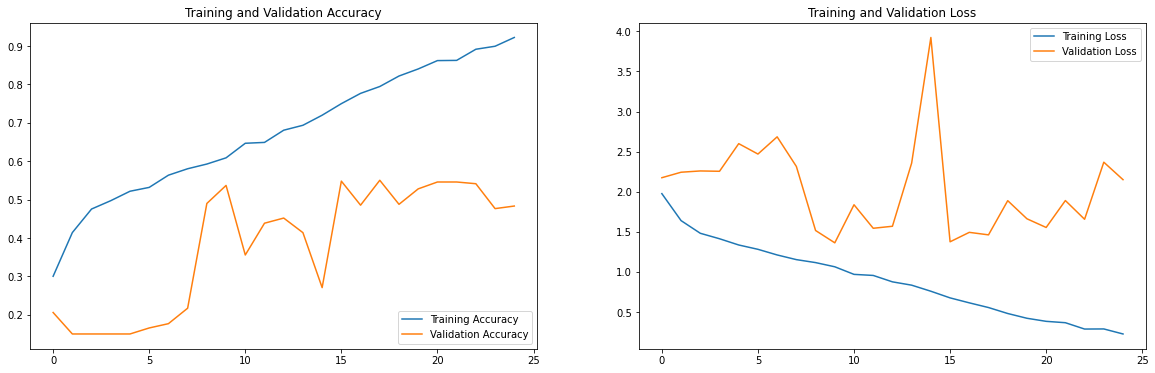

In [34]:
 plt_model (m2_fit,epochs=25)

Observation:
There is an overfit in model (Training accuracy is higher than test accuracy)
There are two possible reasons:
1) The training data images and the validation images have significan differences and hence the model is unable to take the learning forward. This can be attempted to fix by using Data augmentation to introduce some cropping , rotation etc
2) Class imbalance - there is an imbalance of classes across training and test sets and model is not able to train efficently

### Define a sequential Data Augmentation Layer

In [35]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [40]:
model3 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(180,180, 3)),
  data_augmentation,
  tf.keras.layers.Conv2D(64, 3, padding="same",activation='relu'),
  tf.keras.layers.Conv2D(64, 3, padding="same",activation='relu'),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)), 
  tf.keras.layers.Conv2D(128, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(128, 3, padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)),
  tf.keras.layers.Conv2D(256, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(256, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(256, 3, padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(),     
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(len(class_names),activation='softmax')
])

In [41]:
# summary of the model
print(model3.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 180, 180, 64)      1792      
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 180, 180, 64)      36928     
_________________________________________________________________
batch_normalization_16 (Batc (None, 180, 180, 64)      256       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 90, 90, 128)      

In [42]:
# compile the model with adam optimizer
model3.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [43]:
# Training the model
m3_fit = model3.fit(train_ds, batch_size=batch_size,epochs=25,validation_data=val_ds,shuffle=True)

Epoch 1/25
56/56 [==============================] - 22s 379ms/step - loss: 1.9561 - accuracy: 0.2924 - val_loss: 2.1671 - val_accuracy: 0.2058
Epoch 2/25
56/56 [==============================] - 21s 382ms/step - loss: 1.6441 - accuracy: 0.4079 - val_loss: 2.3188 - val_accuracy: 0.1499
Epoch 3/25
56/56 [==============================] - 21s 373ms/step - loss: 1.5045 - accuracy: 0.4654 - val_loss: 2.3319 - val_accuracy: 0.1499
Epoch 4/25
56/56 [==============================] - 22s 391ms/step - loss: 1.4342 - accuracy: 0.4782 - val_loss: 2.9919 - val_accuracy: 0.1499
Epoch 5/25
56/56 [==============================] - 21s 374ms/step - loss: 1.3901 - accuracy: 0.5022 - val_loss: 2.3940 - val_accuracy: 0.1521
Epoch 6/25
56/56 [==============================] - 20s 364ms/step - loss: 1.3711 - accuracy: 0.5112 - val_loss: 2.3219 - val_accuracy: 0.2081
Epoch 7/25
56/56 [==============================] - 22s 386ms/step - loss: 1.3351 - accuracy: 0.5106 - val_loss: 2.6211 - val_accuracy: 0.1767

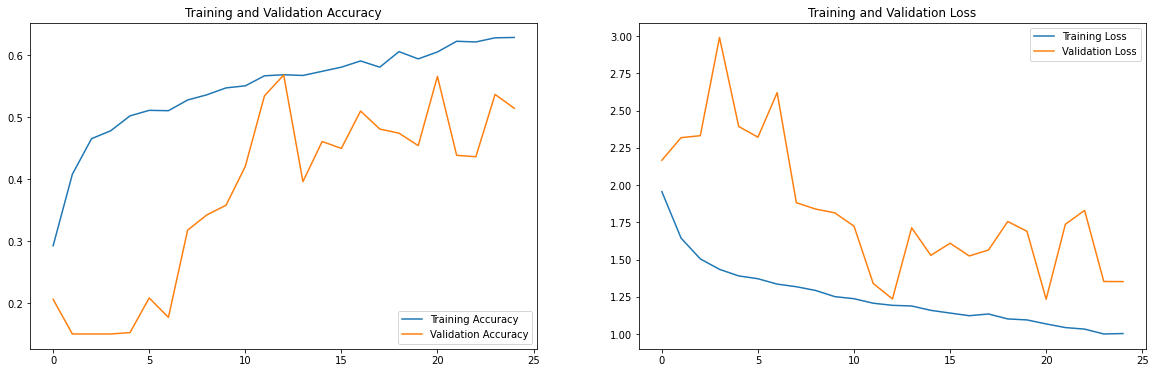

In [44]:
plt_model (m3_fit,epochs=25)

Observation: With data augmentation, the overfitting has reduced however accuracy has fallen
Inferrence: Need to have more training data. There is a class imbalance as well

#### Let us look at the class imbalance

In [45]:
# store the classes in dataframe for easy analysis
class_size_df = pd.DataFrame()

for name in class_names:
    class_size_df=class_size_df.append({'Class':name,'Size':len(list(data_dir_train.glob(name+'/*.jpg')))},ignore_index = True)

class_size_df = class_size_df.set_index('Class')    

In [46]:
class_size_df

,Size
Class,
actinic keratosis,114.0
basal cell carcinoma,376.0
dermatofibroma,95.0
melanoma,438.0
nevus,357.0
pigmented benign keratosis,462.0
seborrheic keratosis,77.0
squamous cell carcinoma,181.0
vascular lesion,139.0


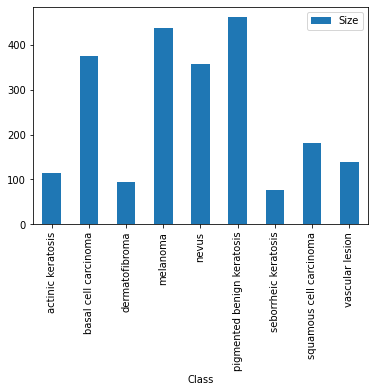

In [47]:
class_size_df.plot.bar()
plt.show()

#### Using Augmentor increase the training data set

In [48]:
!pip install Augmentor
import Augmentor

In [49]:
for i,row in class_size_df.iterrows():
    p = Augmentor.Pipeline('/kaggle/input/melimgs/Train/'+i, output_directory='/kaggle/working/'+i+'/')
    p.flip_left_right(probability=0.3)
    p.flip_top_bottom(probability=0.7)
    p.rotate90(probability=0.1)
    p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(600)

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/actinic keratosis/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F828422DAD0>: 100%|██████████| 600/600 [00:22<00:00, 26.74 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/basal cell carcinoma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F82840F77D0>: 100%|██████████| 600/600 [00:21<00:00, 27.57 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/dermatofibroma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8284236690>: 100%|██████████| 600/600 [00:22<00:00, 27.00 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/melanoma/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F8284034910>: 100%|██████████| 600/600 [02:12<00:00,  4.52 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/nevus/.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F828407F410>: 100%|██████████| 600/600 [01:50<00:00,  5.43 Samples/s]                  


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/pigmented benign keratosis/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F8284030C10>: 100%|██████████| 600/600 [00:22<00:00, 26.92 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/seborrheic keratosis/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F830C34C050>: 100%|██████████| 600/600 [00:55<00:00, 10.91 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/squamous cell carcinoma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F82841A3F50>: 100%|██████████| 600/600 [00:21<00:00, 28.54 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/vascular lesion/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F82841E11D0>: 100%|██████████| 600/600 [00:22<00:00, 26.44 Samples/s]                  


In [50]:
## A hidden directory virtual_documents is being created in kagggle, removing it
import shutil
shutil.rmtree("/kaggle/working/.virtual_documents")


In [51]:
## Print the total training images generated
data_dir_train_aug = pathlib.Path("/kaggle/working/")
image_count_train_aug = len(list(data_dir_train_aug.glob('*/*.jpg')))
print("Train images count= ", image_count_train_aug)

Train images count=  5400


#### Load the new training images generated through augmentor into train_ds_aug

In [52]:
train_ds_aug = tf.keras.utils.image_dataset_from_directory(
  data_dir_train_aug,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 5400 files belonging to 9 classes.
Using 4320 files for training.


In [53]:
  
val_ds_aug = tf.keras.utils.image_dataset_from_directory(
  data_dir_train_aug,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size) 

Found 5400 files belonging to 9 classes.
Using 1080 files for validation.


In [54]:
class_names_aug = train_ds_aug.class_names
print(class_names_aug)
print("Total Clases:" , len(class_names_aug))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Total Clases: 9


In [55]:
class_size_aug_df = pd.DataFrame()

for name in class_names_aug:
    class_size_aug_df=class_size_aug_df.append({'Class':name,'Size':len(list(data_dir_train_aug.glob(name+'/*.jpg')))},ignore_index = True)

class_size_aug_df = class_size_aug_df.set_index('Class')    

In [56]:
class_size_aug_df

,Size
Class,
actinic keratosis,600.0
basal cell carcinoma,600.0
dermatofibroma,600.0
melanoma,600.0
nevus,600.0
pigmented benign keratosis,600.0
seborrheic keratosis,600.0
squamous cell carcinoma,600.0
vascular lesion,600.0


In [57]:
model4 = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255, input_shape=(180,180, 3)),
  tf.keras.layers.Conv2D(64, 3, padding="same",activation='relu'),
  tf.keras.layers.Conv2D(64, 3, padding="same",activation='relu'),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)), 
  tf.keras.layers.Conv2D(128, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(128, 3, padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)),
  tf.keras.layers.Conv2D(256, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(256, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(256, 3, padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(), 
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.BatchNormalization(),     
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.Conv2D(512, 3, padding="same", activation='relu'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(len(class_names),activation='softmax')
])

In [58]:
# summary of the model
print(model4.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 180, 180, 64)      1792      
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 180, 180, 64)      36928     
_________________________________________________________________
batch_normalization_20 (Batc (None, 180, 180, 64)      256       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 90, 90, 128)       73856     
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 90, 90, 128)      

In [59]:
# compile the model with adam optimizer
model4.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [60]:
# Training the model
m4_fit = model4.fit(train_ds_aug,epochs=35,validation_data=val_ds_aug,shuffle=True)

Epoch 1/35
135/135 [==============================] - 59s 423ms/step - loss: 1.9938 - accuracy: 0.2465 - val_loss: 2.2933 - val_accuracy: 0.0917
Epoch 2/35
135/135 [==============================] - 53s 389ms/step - loss: 1.6056 - accuracy: 0.3808 - val_loss: 2.3545 - val_accuracy: 0.0926
Epoch 3/35
135/135 [==============================] - 52s 381ms/step - loss: 1.4824 - accuracy: 0.4271 - val_loss: 2.0097 - val_accuracy: 0.2120
Epoch 4/35
135/135 [==============================] - 53s 387ms/step - loss: 1.3774 - accuracy: 0.4727 - val_loss: 1.4949 - val_accuracy: 0.4102
Epoch 5/35
135/135 [==============================] - 53s 384ms/step - loss: 1.3241 - accuracy: 0.4933 - val_loss: 1.3998 - val_accuracy: 0.4972
Epoch 6/35
135/135 [==============================] - 54s 392ms/step - loss: 1.2443 - accuracy: 0.5171 - val_loss: 1.7051 - val_accuracy: 0.4009
Epoch 7/35
135/135 [==============================] - 53s 387ms/step - loss: 1.1522 - accuracy: 0.5613 - val_loss: 1.2098 - val_ac

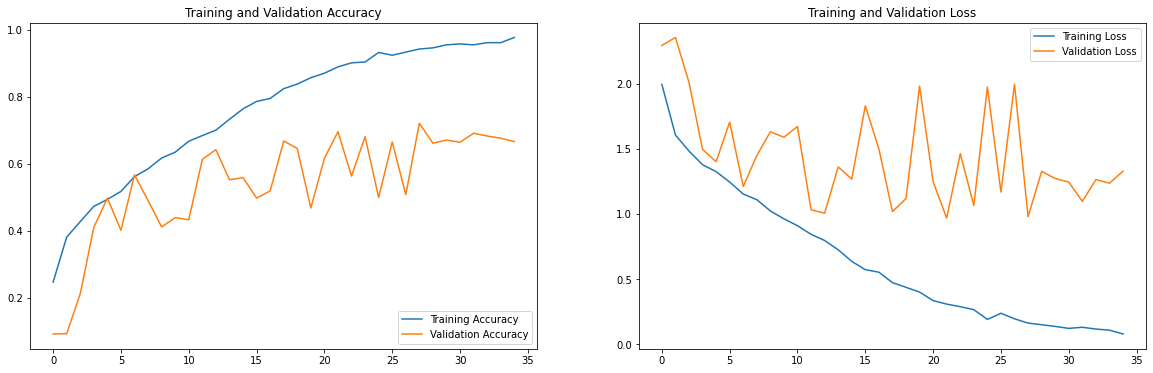

In [61]:
plt_model(m4_fit,epochs=35)

### Make Predictions on Test data

In [62]:
## Load each image in Test directory and make predictions on it
for index,row in test_ds_given_df.iterrows():
    #print("/kaggle/input/melimgs/Test/"+row['GivenClass']+"/"+index)
    img = tf.keras.utils.load_img("/kaggle/input/melimgs/Test/"+row['GivenClass']+"/"+index, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model4.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    test_ds_given_df.at[index,'PredClass']=class_names[np.argmax(score)]
    test_ds_given_df.at[index,'PredConfidence']=100 * np.max(score)

#### Identify the images whose predicted class equals provided class

In [63]:
test_ds_pred_acc=test_ds_given_df[test_ds_given_df.GivenClass==test_ds_given_df.PredClass]

In [64]:
print ('correctly predicted= ',test_ds_pred_acc.shape[0],' Overall accuracy % on prediction =',round(test_ds_pred_acc.shape[0]/test_ds_given_df.shape[0],2)*100)

correctly predicted=  53  Overall accuracy % on prediction = 45.0


In [65]:
test_ds_pred_acc

,GivenClass,PredClass,PredConfidence
GivenFile,,,
ISIC_0024408.jpg,pigmented benign keratosis,pigmented benign keratosis,25.337914
ISIC_0024358.jpg,pigmented benign keratosis,pigmented benign keratosis,25.266090
ISIC_0024402.jpg,vascular lesion,vascular lesion,25.359762
ISIC_0024381.jpg,pigmented benign keratosis,pigmented benign keratosis,22.228195
ISIC_0024422.jpg,pigmented benign keratosis,pigmented benign keratosis,25.350678
ISIC_0024575.jpg,squamous cell carcinoma,squamous cell carcinoma,22.104870
ISIC_0024396.jpg,dermatofibroma,dermatofibroma,24.947417
ISIC_0024450.jpg,squamous cell carcinoma,squamous cell carcinoma,18.800122
ISIC_0024472.jpg,basal cell carcinoma,basal cell carcinoma,20.660275


Accuracy of training improved with more layers and after addressing class imbalance. Still some overfitting is observed. Need to tune model by checking hyperparameters. Over 45% of accuracy seen in the unseen Test data